# Verify the weight of u+p

## Prepare environment and  define parameters 

In [1]:
is_colab = False
import sys
if is_colab:
    try:
        import torch  
        print('Module torch was installed')
    except ImportError:    
        print("Installinng torch 1.8.1")
        !pip install -q torch==1.8.1
    try:
        import torchvision  
        print('Module torchvision was installed')
    except ImportError:    
        print("Installinng torchvision 0.4.0")
        !pip install -q torchvision==0.4.0
    
    try:
        import qiskit  
        print('Module qiskit was installed')
    except ImportError:    
        print("Installinng qiskit 0.14.0")
        !pip install -q qiskit==0.14.0

    !pip install qfnn


import torch
import torchvision

import qiskit
from qiskit import  QuantumCircuit, ClassicalRegister
import numpy as np
import functools

sys.path.append('../')
from src.qfnn.qf_fb.q_output import fire_ibmq,analyze,add_measure
from src.qfnn.qf_circ.n_lyr_circ import N_LYR_Circ
from src.qfnn.qf_circ.u_lyr_circ import U_LYR_Circ
from src.qfnn.qf_circ.p_lyr_circ import P_LYR_Circ
from src.qfnn.qf_fb.c_input import load_data,to_quantum_matrix

print = functools.partial(print, flush=True)






## Load data

In [2]:

################ Zhirui on 12-30-2020 ################
# Parameters of settings
######################################################
interest_num = [3,6]
img_size = 4
 # how many samples per batch 
batch_size = 1 
inference_batch_size = 1


################ Zhirui on 12-30-2020 ################
# path
######################################################
if is_colab:
    data_path = '/content/data' #mnist  path
else: 
    data_path = '/home/hzr/Software/quantum/qc_mnist/pytorch/data'

################ Zhirui on 12-30-2020 ################
#load data and do data preparation
######################################################

train_loader, test_loader = load_data(interest_num,data_path,False,img_size,batch_size,inference_batch_size,False)

for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    print("Batch Id: {}, Target: {}".format(batch_idx,target))
    quantum_matrix = to_quantum_matrix(data)
    break

Batch Id: 0, Target: tensor([1])


## Inference

In [3]:
################ Weiwen on 12-30-2020 ################
# Parameters of the trained model
# The training procedure will be found in another repo
# https://github.com/weiwenjiang/QuantumFlow
######################################################

# Model initialization
weight_1 = torch.tensor([[1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,    1.,  1.],[-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1., -1., -1.]])
weight_2 = torch.tensor([[1.,  -1.],[-1.,  -1.]])
norm_flag = [True,False]
norm_para = torch.tensor([0.3060,0.6940])



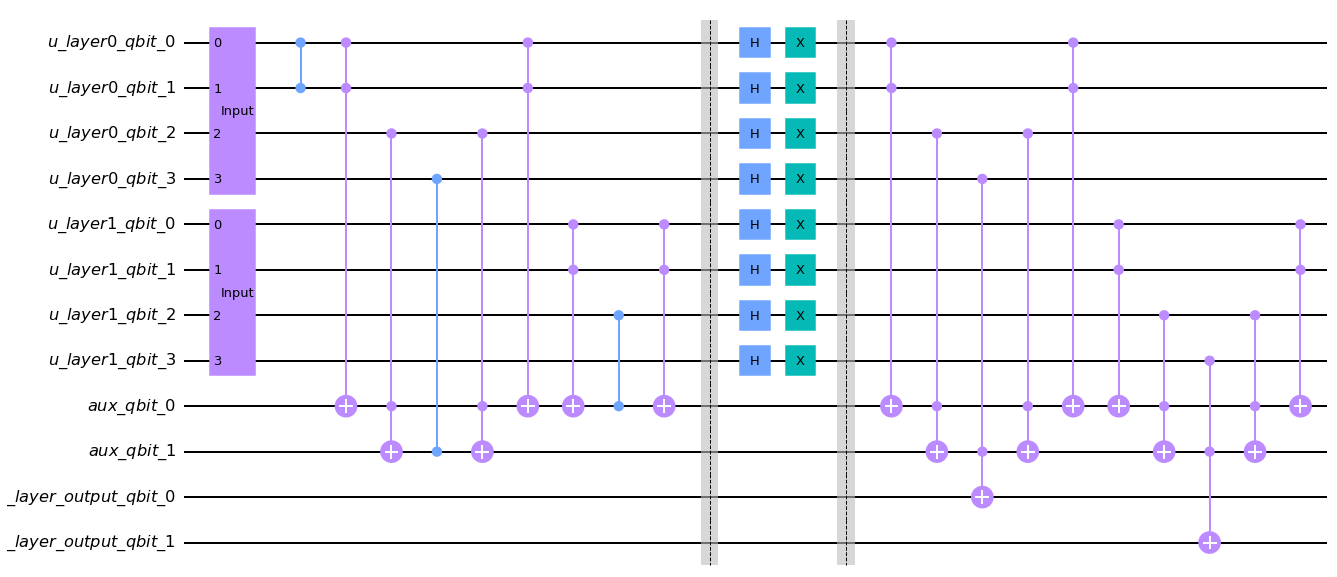

In [4]:
################ Weiwen on 12-30-2020 ################
# Generate the circuit of u-layer
######################################################
#define your input and output number
u_layer = U_LYR_Circ(4,2) 
#init circuit
circuit = QuantumCircuit()
#add input qubit to your circuit
inps = u_layer.add_input_qubits(circuit)

#add auxiliary qubit to your circuit
aux =u_layer.add_aux(circuit)

#add output qubit to your circuit
u_layer_out_qubits = u_layer.add_out_qubits(circuit)

#add ulayer to your circuit
u_layer.forward(circuit,weight_1,inps,u_layer_out_qubits,quantum_matrix,aux)

#show your circuit
if is_colab:
    layout = 'text'
    fold = 300
else:
    layout = 'mpl'
    fold = 50

circuit.draw(layout,fold=fold)



Output layer created!


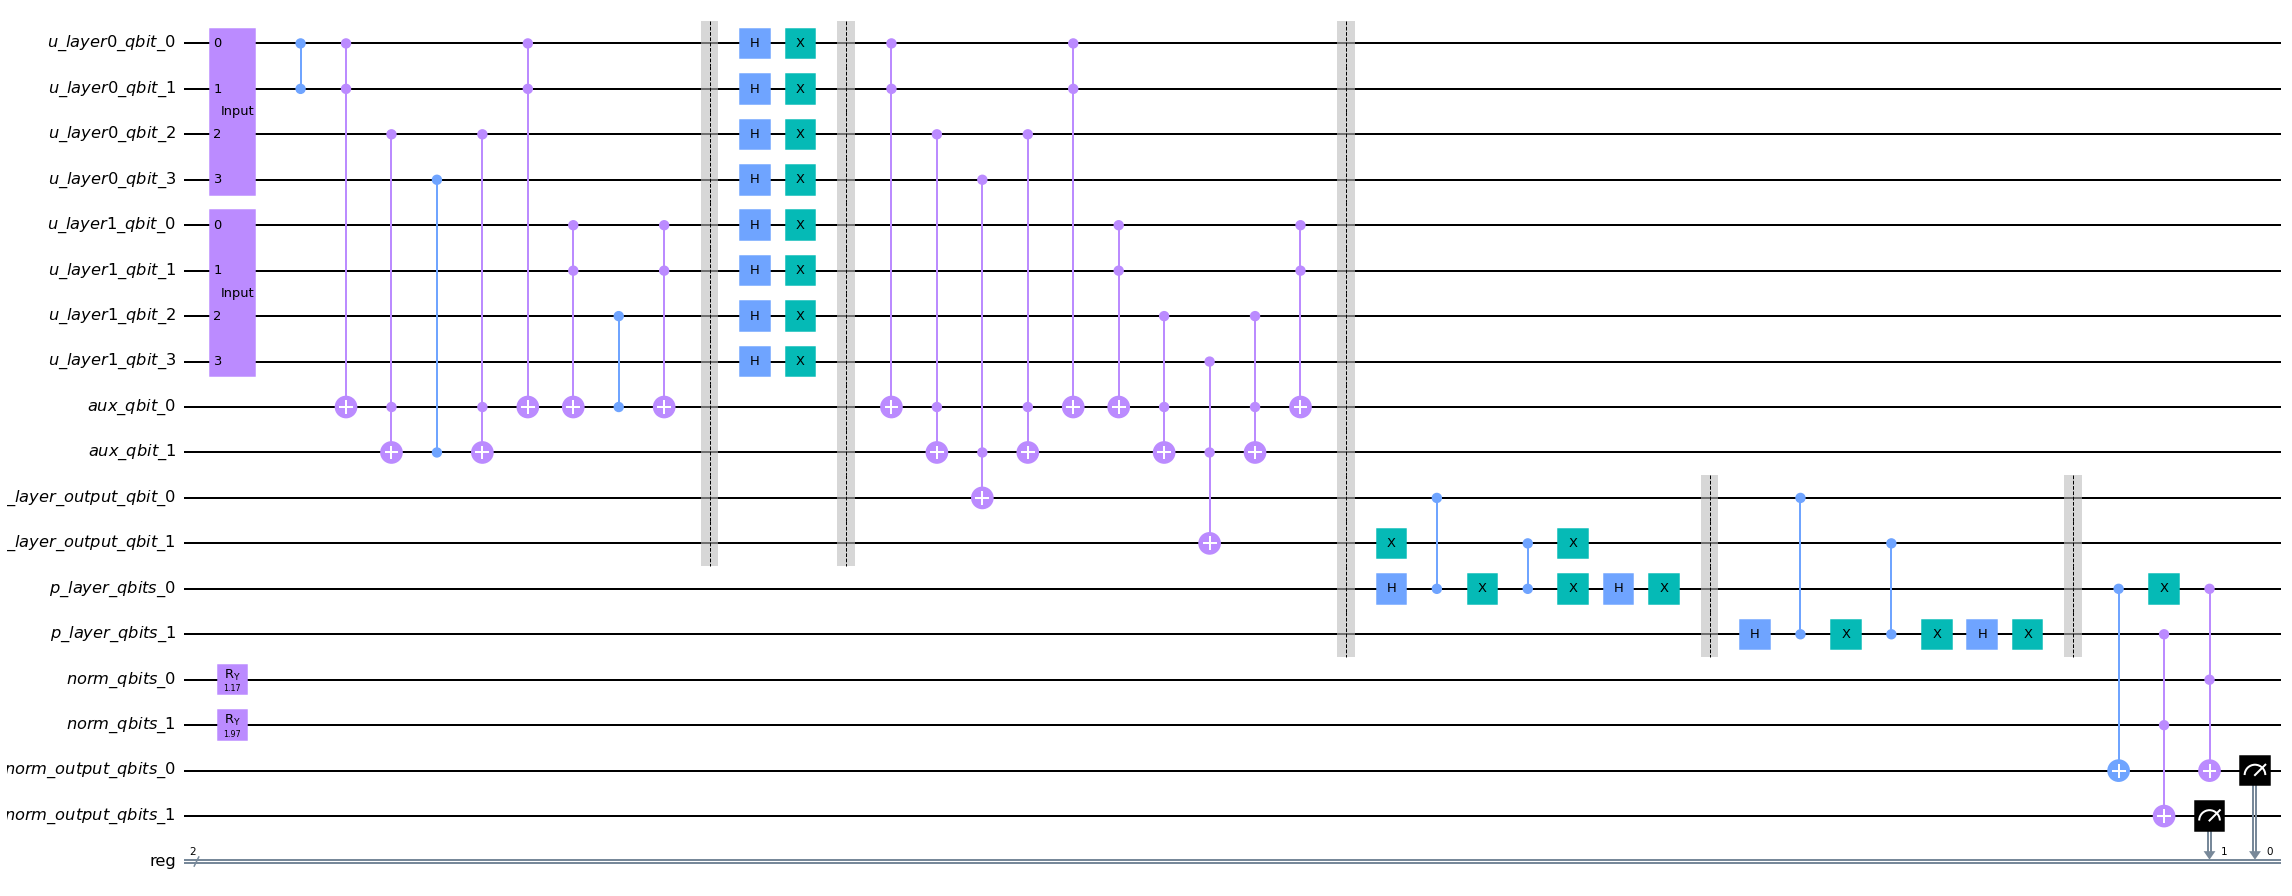

In [5]:
################ Weiwen on 12-30-2020 ################
# Quantum circuit implementation of the output layer
# fundamentals, please see our Nature Communication
# paper (P-LYR) https://arxiv.org/pdf/2006.14815.pdf
######################################################


p_layer = P_LYR_Circ(2,2)
p_layer_output = p_layer.add_out_qubits(circuit)
circuit.barrier()

p_layer.forward(circuit,weight_2,u_layer_out_qubits,p_layer_output)


norm = N_LYR_Circ(2)
norm_qubit = norm.add_norm_qubits(circuit)
norm_output_qubit = norm.add_out_qubits(circuit)
norm.forward(circuit,p_layer_output,norm_qubit,norm_output_qubit,norm_flag,norm_para)


add_measure(circuit,norm_output_qubit,'reg')

print("Output layer created!")

circuit.draw('mpl',fold =300)

### Non-Optimized Circuit v.s. Optimized Circuit

Let's test and compare!


In [6]:
################ Weiwen on 12-30-2020 ################
# Quantum simulation
######################################################

# Optimized one
qc_shots=8192
opt_counts = fire_ibmq(circuit,qc_shots,True)
print("="*10,"Optimized Circuit","="*10)
(opt_mycount,bits) = analyze(opt_counts)
opt_class_prob=[]
for b in range(bits):
    opt_class_prob.append(float(opt_mycount[b])/qc_shots)


print("="*10,"Optimized Circuit","="*10)
print("Optimized Circuit Depth:",circuit.depth())
print("Result of optimized QC:",opt_class_prob)
print("Prediction class: {}".format(opt_class_prob.index(max(opt_class_prob))))
print("Target class: {}".format(target[0]))
if opt_class_prob.index(max(opt_class_prob))==target[0]:
    print("Correct prediction")
else:
    print("Incorrect prediction")
print("="*30)

========== Optimized Circuit ==========
========== Optimized Circuit ==========
Optimized Circuit Depth: 40
Result of optimized QC: [0.4630126953125, 0.5382080078125]
Prediction class: 1
Target class: 1
Correct prediction
